## Import Libraries

In [40]:
%matplotlib notebook
#%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from psana import *
from psalg_ext import peak_finder_algos


from psana.hexanode.PyCFD import PyCFD
from psana.hexanode.HitFinder import HitFinder

from psana.pop import POP

from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage import gaussian_filter1d

# 1. Electron Data

## 1.1 Opal image from single shot

In [38]:
def opl_img(exp,run,num):
    ds = DataSource(exp=exp,run=run)
    myrun = next(ds.runs())
    opal = myrun.Detector('tmoopal')
    
    i = 0
    for nevt,evt in enumerate(myrun.events()):
        if nevt<num:
            continue
        try:
            img = opal.raw.image(evt)
            
            plt.figure()
            plt.imshow(img)
            plt.xlabel('X (pixle)')
            plt.ylabel('Y (pixle)')       
            plt.tight_layout()
            break

        except:
            continue      

    return img.copy()

<IPython.core.display.Javascript object>


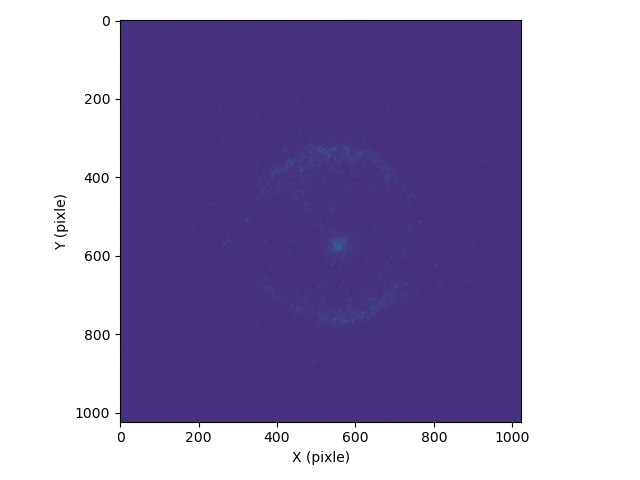

In [39]:
img = opl_img(exp='tmoc00118',run=178,num=6)


## 1.2 Electron peak finding and accumulation from opal images

In [4]:
def Accum_img_pks(exp,run,num):
    ds = DataSource(exp=exp,run=run)
    myrun = next(ds.runs())
    opal = myrun.Detector('tmoopal')
    xbins = np.arange(0,1025)
    ybins = np.arange(0,1025)
    imgs = np.zeros((1024,1024))
    algos = peak_finder_algos(pbits=0)
    mask = np.ones_like(imgs, dtype=np.uint16)
    for nevt,evt in enumerate(myrun.events()):
        try:
            img = opal.raw.image(evt)
        except:
            continue
            
        t0 = time.time()
        pks = algos.peak_finder_v4r3_d2(img, mask, thr_low=30, thr_high=60, rank=2, r0=4, dr=1)
        coords = np.array([[pk.col,pk.row] for pk in pks])       
        img1,_,_ = np.histogram2d(coords[:,0],coords[:,1],bins=(xbins,ybins))
        imgs += img1
         
        if nevt>num:
            break
            
    return imgs

In [5]:
imgs= np.flipud(np.rot90(Accum_img_pks(exp='tmoc00118',run=132,num=1000)))

<IPython.core.display.Javascript object>


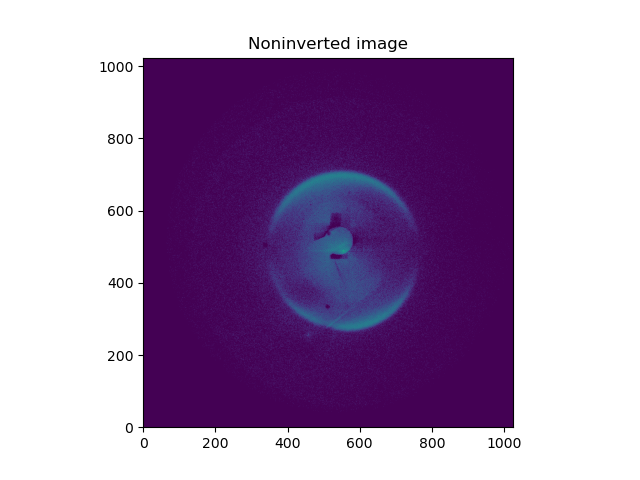

Text(0.5, 1.0, 'Noninverted image')

In [33]:
plt.figure()
plt.imshow(np.log10(imgs+1),extent=[0,1024,0,1024])
plt.title('Noninverted image')

## 1.2 Inverting the accumulated image

In [8]:
pop = POP.POP(lmax=4,reg=0,alpha=4e-4,img=imgs,X0=551,Y0=535,Rmax=450,
          RBFs_fnm='/cds/home/x/xiangli/Share/RBFs512.pkl',edge_w=10)   

Start initialization......
Loading RBFs from /cds/home/x/xiangli/Share/RBFs512.pkl......
RBFs loaded.
Continue initialization......
Initialization completed, ready to peel!


In [9]:
pop.Peel(imgs)
slice_img = pop.GetSlice()
rbins,DistR = pop.GetRadialDist()
Ebins,DistE = pop.GetEnergyDist()  

<IPython.core.display.Javascript object>


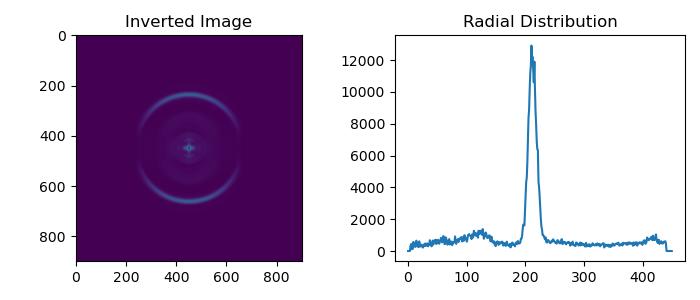

In [32]:
plt.figure(figsize=(7,3))
plt.subplot(121)
plt.imshow(slice_img)
plt.title('Inverted Image')
plt.subplot(122)
plt.plot((rbins[1:]+rbins[:-1])/2,DistR)
plt.title('Radial Distribution')
#plt.xlim([0,35])
plt.tight_layout()

# 1. Ion Data

## Waveforms from single event

In [13]:
def WF(exp,run,num):
    ds = DataSource(exp=exp,run=run)
    myrun = next(ds.runs())
    hsd = myrun.Detector('hsd')

    for nevt,evt in enumerate(myrun.events()):
        if nevt<num:
            continue
        else:
            try:

                wfs = hsd.raw.waveforms(evt)
                t1 = wfs[0]['times']
                
                inds = (t1>9e-6)&(t1<10e-6)

                plt.figure(figsize=(9,10))

                plt.subplot(3,2,1),plt.plot(t1,gaussian_filter1d(wfs[0][0],1),label='MCP')
                plt.legend(loc='best')
                plt.ylabel('Signal (mV)')
                plt.xlabel('Time (s)')                

                plt.subplot(3,2,2),plt.plot(t1,wfs[2][0],label='x1')               
                plt.legend(loc='best')
                plt.ylabel('Signal (mV)')
                plt.xlabel('Time (s)')

                
                plt.subplot(3,2,3),plt.plot(t1,wfs[4][0],label='x2')            
                plt.legend(loc='best')
                plt.ylabel('Signal (mV)')
                plt.xlabel('Time (s)')

                plt.subplot(3,2,4),plt.plot(t1,wfs[5][0],label='y1')            
                plt.legend(loc='best')
                plt.ylabel('Signal (mV)')
                plt.xlabel('Time (s)')


                plt.subplot(3,2,5),plt.plot(t1,wfs[8][0],label='y2')           
                plt.legend(loc='best')
                plt.ylabel('Signal (mV)')
                plt.xlabel('Time (s)')

                plt.subplot(3,2,6),plt.plot(t1,wfs[6][0],label='K-Tof')          
                plt.legend(loc='best')
                plt.ylabel('Signal (mV)')
                plt.xlabel('Time (s)')

                plt.tight_layout()
                break

            except Exception as e:
                print(e)
        return

<IPython.core.display.Javascript object>


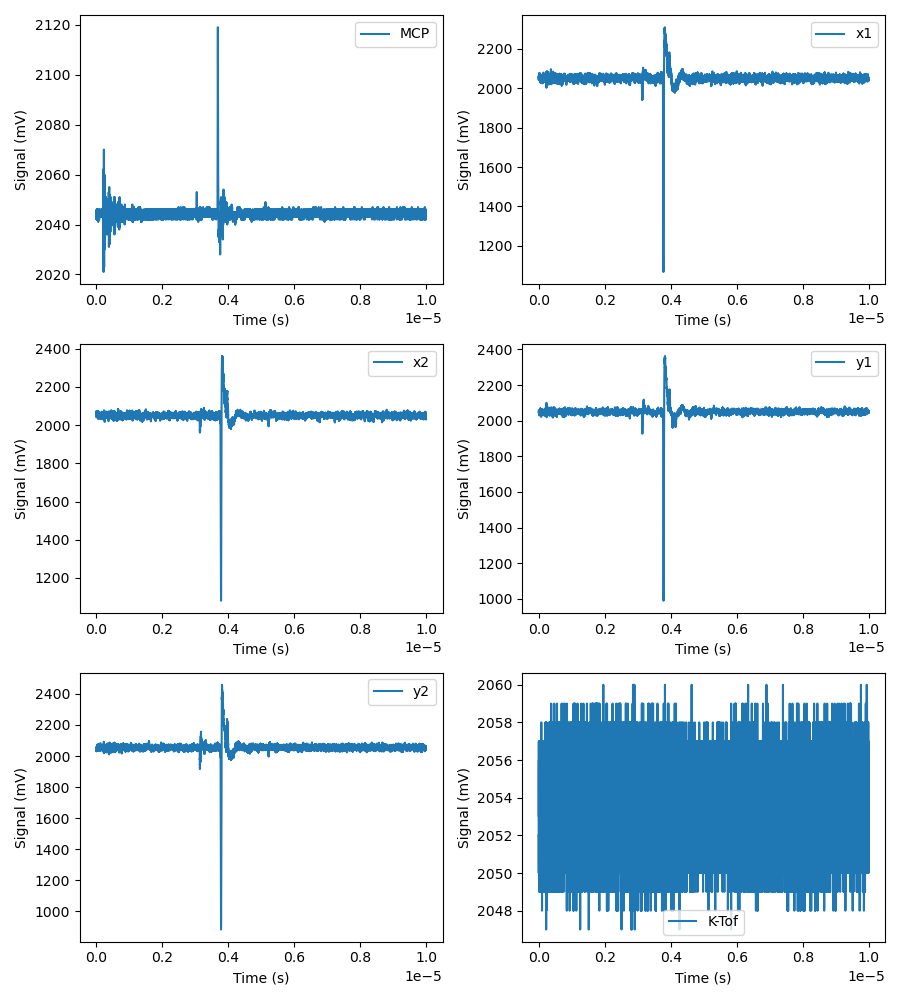

In [14]:
WF(exp='tmoc00118',run=178,num=6)

## 1.2 Ion detector image and time of flight spectrum

In [30]:
def HitReconstructor(exp,run,num,CFDs,HF):

    ds = DataSource(exp=exp,run=run)    
    myrun = next(ds.runs())
    hsd = myrun.Detector('hsd')
    channels = {'mcp':0,'x1':2,'x2':4,'y1':5,'y2':8}
    
    xs = np.empty([0,])
    ys = np.empty([0,])
    ts = np.empty([0,])    
    
    xbins = np.linspace(-50,50,200)
    tbins = np.linspace(0,10000,5000)  
    
    h_t = np.zeros((len(tbins)-1,))
    h_xy = np.zeros((len(xbins)-1,len(xbins)-1))
    
    for nevt,evt in enumerate(myrun.events()):
        t_pks = {}
        try:       
            wfs = hsd.raw.waveforms(evt)
            t1 = wfs[0]['times']

            for i,k in enumerate(channels.keys()):

                t_pks[k] = 1e9*np.array(CFDs[k].CFD(gaussian_filter1d(wfs[channels[k]][0],1),t1))
                
            HF.FindHits(t_pks['mcp'],t_pks['x1'],t_pks['x2'],t_pks['y1'],t_pks['y2'])
            xs1,ys1,ts1 = HF.GetXYT()
       

            xs = np.concatenate([xs,xs1],axis=0)
            ys = np.concatenate([ys,ys1],axis=0)
            ts = np.concatenate([ts,ts1],axis=0)     
        
            if nevt%100==0:
                h_t1,_ = np.histogram(ts,bins=tbins)
                h_xy1,_,_ = np.histogram2d(xs,ys,bins=[xbins,xbins])
                h_t += h_t1
                h_xy += h_xy1
                
                xs = np.empty([0,])
                ys = np.empty([0,])
                ts = np.empty([0,])                 

        except Exception as e:
            print(e)
            if nevt>num:
                break            
            continue
            
        if nevt>num:
            break
                

    plt.figure(figsize=(9,5))                           
        
    plt.subplot(121)

    
    im = plt.imshow(h_xy+1,extent=[xbins[0],xbins[-1],xbins[0],xbins[-1]],norm=LogNorm(vmin=1, vmax=h_xy.max()+1))
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    ax.set_title('X - Y')
    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)') 
    
    plt.subplot(122)

    
    plt.plot(tbins[:-1],h_t)
    plt.title('Time of Flight')
    plt.xlabel('T (ns)')
    plt.ylabel('Yield (arb. units)') 
    plt.tight_layout()
    return

In [26]:
CFD_params = {'x1': {'sample_interval': 1.68269e-10,
  'fraction': 0.35,
  'delay': 5.850000000000001e-09,
  'polarity': 'Negative',
  'threshold': 30,
  'walk': 0,
  'timerange_low': 0,
  'timerange_high': 1e-05,
  'offset': 2049},
 'x2': {'sample_interval': 1.68269e-10,
  'fraction': 0.35,
  'delay': 5.850000000000001e-09,
  'polarity': 'Negative',
  'threshold': 30,
  'walk': 0,
  'timerange_low': 0,
  'timerange_high': 1e-05,
  'offset': 2049},
 'y1': {'sample_interval': 1.68269e-10,
  'fraction': 0.35,
  'delay': 5.850000000000001e-09,
  'polarity': 'Negative',
  'threshold': 30,
  'walk': 0,
  'timerange_low': 0,
  'timerange_high': 1e-05,
  'offset': 2048},
 'y2': {'sample_interval': 1.68269e-10,
  'fraction': 0.35,
  'delay': 5.850000000000001e-09,
  'polarity': 'Negative',
  'threshold': 30,
  'walk': 0,
  'timerange_low': 0,
  'timerange_high': 1e-05,
  'offset': 2053},
 'mcp': {'sample_interval': 1.68269e-10,
  'fraction': 0.35,
  'delay': 5.850000000000001e-09,
  'polarity': 'Positive',
  'threshold': 3,
  'walk': 0,
  'timerange_low': 0,
  'timerange_high': 1e-05,
  'offset': 2044}}

Hit_params = {'runtime_u' : 90,
          'runtime_v' : 100,
          'tsum_avg_u' : 180,
          'tsum_avg_v' : 186.5,
          'tsum_hw_u' : 2.5,
          'tsum_hw_v' : 2.5,
          'f_u' : 1,
          'f_v' : 1,
          'Rmax': 40
         }

cns = ['x1','x2','y1','y2','mcp']
CFDs = {}
for cn in cns:
    CFDs[cn] = PyCFD(CFD_params[cn])
HF = HitFinder(Hit_params)

Newton Polynomial escaped.
Newton Polynomial escaped.
Newton Polynomial escaped.
Newton Polynomial escaped.
Newton Polynomial escaped.
Newton Polynomial escaped.
Newton Polynomial escaped.
Newton Polynomial escaped.
Newton Polynomial escaped.
Newton Polynomial escaped.


<IPython.core.display.Javascript object>


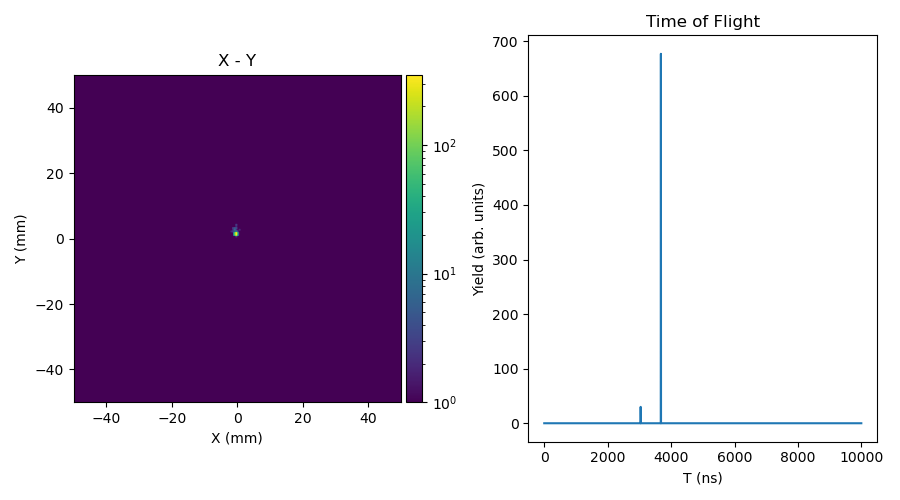

In [31]:
HitReconstructor(exp='tmoc00118',run=178,num=1000,CFDs=CFDs,HF=HF)